In [2]:
# Die benötigten Module werden importiert
import os, PIL, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt



# Die Trainingsdaten werden in einem Ordner gespeichert
train_folder = 'data/train/'


In [3]:
# Die Daten aus dem Ordner werden in einer Liste gespeichert

filenames=[]
for filename in os.listdir(train_folder):
    filenames.append(filename)

# Eine Liste mit den Labels wird erstellt    
labels=[]
# Die Liste Filename wird durchgegangen und wenn der Dateiname mit 'dog' beginnt, wird eine 1 angehängt, sonst eine 0
for filename in filenames:
    if filename[:3]=='dog':
        labels.append(1)
    else:
        labels.append(0)


# Es wird ein Dictionary erstellt, welches die Labels den Klassen zuordnet        
classes={0:'cat', 1:'dog'}

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/'

In [ ]:
# Es wird eine Funktion erstellt, welche die ein Batch mit Bildern lädt
def load_batch_of_images(batch_filenames):
    # load images as PIL images
    # Die Bilder werden in der Liste batch_images gespeichert
    batch_images=[]
    # In der Schleife werden die Bilder aus dem Ordner geladen und in der Liste batch_images gespeichert
    for filename in batch_filenames:
        image=PIL.Image.open(train_folder+filename)
        batch_images.append(image)
    return batch_images

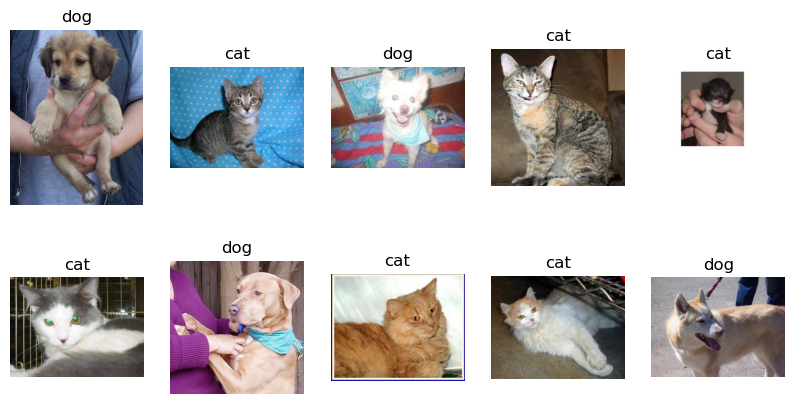

In [ ]:
# Es wird ein Batch mit 10 Bildern geladen und darstellt
sample_images=load_batch_of_images(filenames[:10])
fig, ax=plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(sample_images[i])
    ax[i//5,i%5].set_title(classes[labels[i]])
    ax[i//5,i%5].axis('off')
plt.show()

In [ ]:
# Es wird eine Funktion erstellt, welche ein Batch mit Bildern als Tensoren lädt
# ALs Parameter werden die Dateinamen, die Labels, der Startindex und die Batchgröße übergeben
def load_batch_as_tensors(filenames, labels, start_idx, batch_size):
    # Die Dateinamen werden in der Liste batch_filenames gespeichert und reichen von start_idx bis start_idx+batch_size
    batch_filenames=filenames[start_idx:start_idx+batch_size]
    # Die Bilder werden anhand der Dateinamen von batch_filenames geladen und in der Liste batch_images gespeichert
    batch_images=load_batch_of_images(batch_filenames)
    # Die Labels werden in der Liste batch_labels gespeichert
    batch_labels=[labels[start_idx+i] for i in range(batch_size)]
    # Die Bilder werden in Tensoren umgewandelt
    batch_tensors=[torchvision.transforms.ToTensor()(image) for image in batch_images]
    # Die Bilder werden auf eine Größe von 224x224 Pixeln skaliert
    batch_tensors=[torchvision.transforms.Resize((224,224), antialias=True)(tensor) for tensor in batch_tensors]
    return torch.stack(batch_tensors), torch.tensor(batch_labels, dtype=torch.long)

# Es wird überprüft, ob die Funktion load_batch_as_tensors funktioniert
xb, yb=load_batch_as_tensors(filenames, 0,10)
print("xb shape", xb.shape)
print("yb shape", len(yb))
yb

xb shape torch.Size([10, 3, 224, 224])
yb shape 10


tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [ ]:
# Es werden mit der Funktion train_test_split die Trainings- und Testdaten aufgeteilt
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Es wird ein Neuroales Netz erstellt mit 4 Convolutional Layern und 2 Fully Connected Layern



class DogsAndCatsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        # Die Layer werden sequenziell ausgeführt
        self.layer1=torch.nn.Sequential(
            # Die Convolutional Layer haben eine Kernelgröße von 3x3 Pixeln und eine Padding von 1 Pixel
            # Die Convolutional Layer haben eine Stride von 1 - 2 Pixel
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # Die Max Pooling Layer haben eine Kernelgröße von 2x2 Pixeln und eine Stride von 2 Pixel
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            # Die Convolutional Layer haben die Aktivierungsfunktion ReLU
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            # Die Dropout Layer hat eine Dropout Rate von 20%
            torch.nn.Dropout(p)
        ) # 32x112x112
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(p)
        ) # 128x28x28
        self.layer3=torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(p)
        ) # 256x7x7
        self.layer4=torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.Dropout(p)
        ) # 512x2x2
        self.fc1=torch.nn.Sequential(
            torch.nn.Linear(512*2*2, 1000),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1000)
        )
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(1000, 2),
            # der zweite Fully Connected Layer hat die Aktivierungsfunktion Softmax
            torch.nn.Softmax(dim=1)
        )
    
    # Eine Funktion für die Forward Propagation wird erstellt
    def forward(self, xb):
        out=self.layer1(xb)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=out.reshape(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

model=DogsAndCatsModel()
model(xb).shape

torch.Size([10, 2])

In [ ]:
# Es wird überprüft, welche Art von Hardware verfügbar ist und die schnellste verfugbare Hardware wird ausgewählt und verwendet

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [ ]:
# Es wird eine Funktion erstellt, welche die Daten in Batches aufteilt und dem Device zuweist
def get_batch(x, y, batch_size):
    batch_count=len(x)//batch_size
    for i in range(0, batch_count, batch_size):
        print(i)
        xb, yb=load_batch_as_tensors(x, i, batch_size)
        yield xb.to(device), yb.to(device)

# Das Modell wird auf das Device geladen
model = DogsAndCatsModel().to(device)
xb, yb = next(get_batch(X_train, y_train, 64))
print(xb.shape)
model(xb).shape

0
torch.Size([64, 3, 224, 224])


torch.Size([64, 2])

In [ ]:
# Es wird die Länge der Trainingsdaten ausgegeben sowie die Form der Batches
print(len(X_train))
for xb, yb in get_batch(X_train, y_train, 64):
    print(xb.shape, yb.shape)
    

20000
0
torch.Size([64, 3, 224, 224]) torch.Size([64])
64
torch.Size([64, 3, 224, 224]) torch.Size([64])
128
torch.Size([64, 3, 224, 224]) torch.Size([64])
192
torch.Size([64, 3, 224, 224]) torch.Size([64])
256
torch.Size([64, 3, 224, 224]) torch.Size([64])


In [ ]:
# Es wird eine Accuracy Funktion erstellt
def get_accuracy(x, y):
    preds = model(x)
    preds = torch.argmax(preds, dim=1)
    correct=sum(preds == y)
    return correct.item()/len(x)

In [ ]:
# eigenes Modell wird erstellt
model = DogsAndCatsModel().to(device)
lr=0.01
batch_size=128

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

def train_batch(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    optimizer.step()
    return loss.item()

def train_epoch(x, y):
    losses=[]
    for xb, yb in tqdm(get_batch(x, y, batch_size), total=len(x)//batch_size):
        losses.append(train_batch(xb, yb))
    return losses, get_accuracy(x, y)


In [ ]:
losses, acc=train_epoch(X_train, y_train)
plt.plot(losses)
print("accuracy: " , acc)

  0%|          | 0/156 [00:00<?, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str,

In [ ]:
losses, acc=train_epoch(X_train, y_train)
plt.plot(losses)
print("accuracy: " , acc)

In [ ]:
losses, acc=train_epoch(X_train, y_train)
plt.plot(losses)
print("accuracy: " , acc)

In [ ]:
losses, acc=train_epoch(X_train, y_train)
plt.plot(losses)
print("accuracy: " , acc)

In [ ]:
losses, acc=train_epoch(X_train, y_train)
plt.plot(losses)
print("accuracy: " , acc)

In [ ]:
losses, acc=train_epoch(X_train, y_train)
plt.plot(losses)
print("accuracy: " , acc)